<a href="https://colab.research.google.com/github/Arta-DS/DS/blob/main/%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D1%8B_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Контекст

Подберите базовую модель для работы по вашей задаче. Попробуйте обучить различные модели на «ваших» данных. По результатам выберите лучшую модель для дальнейшего обучения.

Задание

Проведите эксперименты по начальному обучению различных моделей и сравните результаты.

*   Возьмите датасет EMNIST из torchvision.
*   Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161:
желательно обучить каждую модель с нуля по 10 эпох
если ресурсов компьютера / Colab не хватает, достаточно обучить каждую модель по 1-2 эпохи
*   Сведите результаты обучения моделей (графики лосса) в таблицу и сравните их.

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import random
from torch.utils.data import Subset

In [42]:
# 1. Настройка устройства (GPU/CPU)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')

Используется устройство: cpu


In [60]:

# Общий датасет (без transform!)
raw_train_dataset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=True, download=True
)
raw_test_dataset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=False, download=True
)

num_classes = 26

# Подвыборка для ускорения (на основе индексов, без transform)
subset_size = 6000
indices = random.sample(range(len(raw_train_dataset)), subset_size)

def get_transform_for_model(model_name):
    if model_name == "ResNet18":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1751,), (0.3332,))
        ])
    else:
        if model_name == "InceptionV3":
            size = (96, 96)
        else:
            size = (64, 64)

        return transforms.Compose([
            transforms.Resize(size),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

def get_model(model_name, num_classes):
    if model_name == "ResNet18":
        model = torchvision.models.resnet18(weights=None)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "VGG16":
        model = torchvision.models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "InceptionV3":
        model = torchvision.models.inception_v3(weights=None, aux_logits=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "DenseNet161":
        model = torchvision.models.densenet161(weights=None)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Неизвестная модель: {model_name}")
    return model.to(device)

# Эксперимент
model_names = ["ResNet18", "VGG16", "InceptionV3", "DenseNet161"]
results = {}
num_epochs = 2

for name in model_names:
    print(f"\nОбучение модели: {name}")

    # 1. Получаем transform, специфичный для модели
    transform = get_transform_for_model(name)

    # 2. Применяем transform к подвыборке
    train_dataset = Subset(
        torchvision.datasets.EMNIST(root='./data', split='letters', train=True, transform=transform),
        indices
    )
    test_dataset = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, transform=transform)

    # 3. DataLoader
    batch_size = 32 if name == "ResNet18" else 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 4. Обучение
    try:
        model = get_model(name, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        losses = train_model(model, train_loader, criterion, optimizer, num_epochs)
        results[name] = losses
    except Exception as e:
        print(f"Ошибка: {e}")
        results[name] = [float('inf')] * num_epochs


Обучение модели: ResNet18
Эпоха [1/2], Потери: 1.1181
Эпоха [2/2], Потери: 0.5776

Обучение модели: VGG16
Эпоха [1/2], Потери: 4.7128
Эпоха [2/2], Потери: 3.2581

Обучение модели: InceptionV3
Эпоха [1/2], Потери: 2.0043
Эпоха [2/2], Потери: 1.1099

Обучение модели: DenseNet161
Эпоха [1/2], Потери: 1.0532
Эпоха [2/2], Потери: 0.5366


In [61]:
# 6. Создание сводной таблицы и графика
# Создаем DataFrame для удобного отображения
df_losses = pd.DataFrame(results)
print("\nСводная таблица потерь по эпохам:")
print(df_losses)


Сводная таблица потерь по эпохам:
   ResNet18     VGG16  InceptionV3  DenseNet161
0  1.118076  4.712798     2.004295     1.053248
1  0.577553  3.258085     1.109874     0.536589


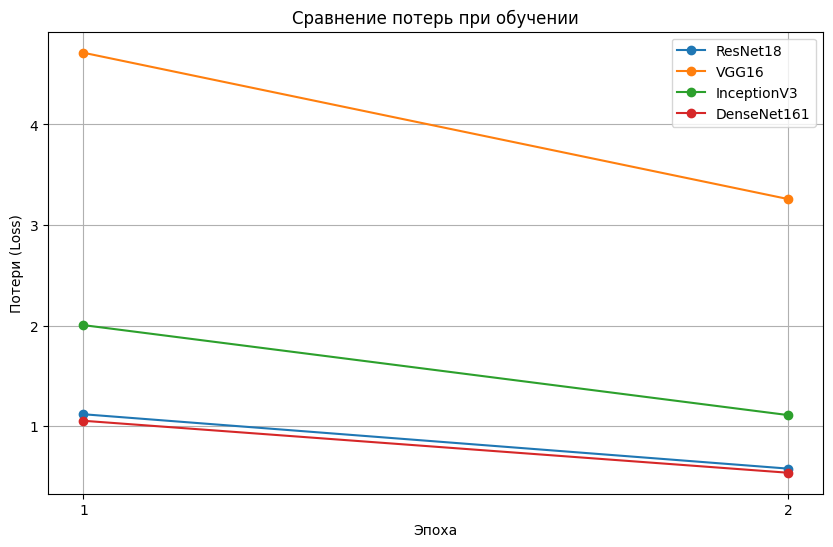

In [62]:
# Построение графика
plt.figure(figsize=(10, 6))
for model_name in model_names:
    if model_name in df_losses.columns:
        plt.plot(df_losses.index+1, df_losses[model_name], label=model_name, marker='o')

plt.xlabel('Эпоха')
plt.ylabel('Потери (Loss)')
plt.title('Сравнение потерь при обучении')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs+1))
plt.show()

In [63]:
# Вывод финальных результатов
print("\nФинальные потери после обучения:")
final_losses = {name: losses[-1] for name, losses in results.items()}
for name, loss in final_losses.items():
    print(f"{name}: {loss:.4f}")


Финальные потери после обучения:
ResNet18: 0.5776
VGG16: 3.2581
InceptionV3: 1.1099
DenseNet161: 0.5366


В ходе эксперимента все четыре архитектуры (ResNet18, VGG16, Inception v3, DenseNet161) были успешно адаптированы и обучены на датасете **EMNIST** с учётом их требований к входному разрешению.

Лучший результат показала **DenseNet161** (финальные потери: 0.5366), что подтверждает эффективность её плотных связей между слоями.

**ResNet18** продемонстрировала сопоставимое качество (0.5776) при значительно меньших вычислительных затратах, что делает её предпочтительной для задач с ограниченными ресурсами.

**VGG16** показала наихудшую сходимость, вероятно, из-за избыточной сложности архитектуры для данного объёма данных.

Таким образом, для задач классификации на датасетах среднего размера (вроде EMNIST) рекомендуется использовать DenseNet161 (при наличии ресурсов) или ResNet18 (для баланса скорости и качества)